## Modeling commute flows with gravity model

This notebook demonstrates a case of intra-city commute modeling with a technique known as gravity model. We may use it to reconstruct (to some extent) the network community structure, which could in turn reveal the important areas/districts accross the city.

The ground-truth data is retreived from LEHD and the gravity model will use the population distribution according to ACS aggregated on zip code level as well as the travel times among zip code pairs derived from Google Maps in order to reconstruct it. We'll evaluate the qualitative performance of the model results by estimating the communities resulting from predicted commute and compare with the ground truth communities from LEHD commute flows.

We'll use the 'pycombo' module for community detection. Please check official module website and github for installation: https://github.com/Casyfill/pyCombo, https://pypi.org/project/pycombo/

The methods comes from our recent paper 

Sobolevsky, S., Campari, R., Belyi, A., & Ratti, C. (2014). General optimization technique for high-quality community detection in complex networks. Physical Review E, 90(1), 012811. 


In [ ]:
# !pip install pycombo

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import scipy.stats as stats
import networkx as nx  # for network analysis
import pycombo  # for community detection 
import geopandas as gpd
import shapely

In [2]:
# population and jobs per zip code 

popJobs = pd.read_csv('popJobs.csv')
popJobs.head()

,ZIPCODE,totalJobs,POPULATION
0,10001,208913,22413.0
1,10002,26789,81305.0
2,10003,98019,55878.0
3,10004,79535,2187.0
4,10005,51207,8107.0


### Travel time between zip codes

The travel time between zipcodes are the transit times retrieved from Google Maps API. The travel time is then averaged by estimating times between 5 random points within each set of zipcodes. 

Metrics like travel cost, distance can also be used insiead of travel time for modeling.

In [3]:
## travel time in minutes between o-d pairs

travelTim = pd.read_csv('AllZipsTimes_new.csv', index_col=None)
travelTim = travelTim[travelTim.time_minutes < 200]
travelTim.loc[(travelTim.O == travelTim.D), 'time_minutes'] = 10  ## assign travel time b/w same zones as 10min
travelTim.head()

,O,D,time_minutes
0,10473,10001,68.0
1,10473,10002,73.0
2,10473,10003,72.0
3,10473,10004,72.0
4,10473,10005,74.0


In [4]:
# ground-truth LEHD commute matrix ('total' referes to the commute numbers)

Z2Z = pd.read_csv('zip2zip.csv', index_col=None)
Z2Z = Z2Z[['w_zip', 'h_zip', 'total']]
Z2Z.head()

,w_zip,h_zip,total
0,10001,10001,1223
1,10001,10002,1547
2,10001,10003,1623
3,10001,10004,180
4,10001,10005,236


## Gravity model

The gravity model has been well-established as a simple yet effective model in transportation commute modeling, as well as modeling migration, trade etc. It estimates the interaction between two locations as the function of some measure of activity in the locations as well the function of distance/time/cost between them. 
Analogous to the Newton's physical law of gravitation, the model formulates the interaction as a declining function of distance/time/cost whereas the interation between locations is positively associated.

Some papers using gravity model in transporation research:


Erlander, S. and Stewart, N.F., 1990. The gravity model in transportation analysis: theory and extensions (Vol. 3). Vsp. (https://books.google.com/books?hl=en&lr=&id=tId3PU1leR8C&oi=fnd&pg=PA1&dq=gravity+model+transportation&ots=MfFDexkIJy&sig=X55b19YCQWLsS5oiLi0JmcQfkoM)

Evans, S.P., 1973. A relationship between the gravity model for trip distribution and the transportation problem in linear programming. Transportation Research, 7(1), pp.39-61.
 (https://www.sciencedirect.com/science/article/pii/0041164773900051)
 
Krings, G., Calabrese, F., Ratti, C., & Blondel, V. D. (2009). Urban gravity: a model for inter-city telecommunication flows. Journal of Statistical Mechanics: Theory and Experiment, 2009(07), L07003. 

Mathematically, the gravity model can be formulated as:

$$M_{i,j} = T_iT_jf(C_{i,j})$$

where $M_{i,j}$ is the interaction between locations $i$ to $j$, $T_i, T_j$ are the measures of 'attraction' associated with origin-destination pairs and $f(C_{i,j})$ is a function of travel time (or distance, cost) $C_{i,j}$ between the locations in question.

For modeling commute flows, the attraction factors can be taken to be socio-economic variables like working population, jobs, etc., which can be subject to fit by introducing parameters in their formulation. For simplicity, we'll keep the attraction terms $T$ constant as the residential population of the concerned locations. Furthermore, we'll take the function of travel time $f(C_{i,j})$ to be a power law function with a single parameter $q$.

Hence, our gravity model can be formulated as:
$$
M_{i,j} = P_iP_j{C_{i,j}}^q
$$

where $P$ is fixed to be the population.

Taking log, the equation transforms to
$$
log(M_{i,j}) = log(k) + log(P_i) + log(P_j) + q*log(C_{i,j})
$$

with $log(k)$ being the intercept. We can estimate the parameter $q$ by fitting a linear model to the data

Note: To avoid any issues with taking log for ground truth mobility numbers, we'll replace 0 values with a small number (0.001) for logarithm feasibility

In [5]:
# merge all data together

allData = Z2Z.merge(travelTim, left_on=['h_zip', 'w_zip'], right_on=['O', 'D'])
allData = allData.merge(popJobs, left_on='O', right_on='ZIPCODE')
allData = allData.merge(popJobs, left_on='D', right_on='ZIPCODE')
allData.rename(columns={'POPULATION_x':'O_population', 'POPULATION_y':'D_population'}, inplace=True)
allData = allData[['O', 'D', 'total', 'time_minutes', 'O_population', 'D_population']]
allData.loc[(allData['O_population'] == 0), 'O_population'] = 1 
allData.loc[(allData['D_population'] == 0), 'D_population'] = 1 
allData.loc[(allData['total'] == 0), 'total'] = 0.001 

allData.head()

,O,D,total,time_minutes,O_population,D_population
0,10001,10001,1223.0,10.0,22413.0,22413.0
1,10002,10001,1547.0,24.0,81305.0,22413.0
2,10003,10001,1623.0,24.0,55878.0,22413.0
3,10004,10001,180.0,27.0,2187.0,22413.0
4,10005,10001,236.0,23.0,8107.0,22413.0


In [6]:
# model function

def gravity(T_i, T_j, C_ij, mob_gt):
    
    X = sm.add_constant(np.log(C_ij))
    y = np.log(mob_gt) - np.log(T_i) - np.log(T_j)
    
    model = sm.OLS(y, X).fit()
    
    return model

In [7]:
model_pop_pop = gravity(allData.O_population, allData.D_population, allData.time_minutes, allData.total)
model_pop_pop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     6942.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:52:41   Log-Likelihood:                -87881.
No. Observations:               33742   AIC:                         1.758e+05
Df Residuals:                   33740   BIC:                         1.758e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.2408      0.136    -38.663      0.000      -5.506      -4.975
time_minutes    -2.7654      0.033    -83.317      0.000      -2.830      -2.700
==============================================================================
Omnibus:                     9435.459   Durbin-Watson:                   0.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20898.352
Skew:                           1.637   Prob(JB):                         0.00
Kurtosis:                       5.037   Cond. No.                         32.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
## estimated value of q parameter

model_pop_pop.params[1]

-2.7653539352177225

Notice that the model has a low R2 score. Let's try another version of the model replacing the 'attraction' factor as (Origin_population-Destination_jobs) instead of (Origin_population-Destination_population). This could be a better metric as number of jobs play a major factor in inter-city commute flows.

In [9]:
# add jobs to data

allDataJobs = allData.merge(popJobs[['ZIPCODE', 'totalJobs']], left_on='D', right_on='ZIPCODE').drop(columns={'ZIPCODE'})
allDataJobs.rename(columns={'totalJobs':'D_jobs'}, inplace=True)
allDataJobs.head()

,O,D,total,time_minutes,O_population,D_population,D_jobs
0,10001,10001,1223.0,10.0,22413.0,22413.0,208913
1,10002,10001,1547.0,24.0,81305.0,22413.0,208913
2,10003,10001,1623.0,24.0,55878.0,22413.0,208913
3,10004,10001,180.0,27.0,2187.0,22413.0,208913
4,10005,10001,236.0,23.0,8107.0,22413.0,208913


In [10]:
model_pop_jobs = gravity(allDataJobs.O_population, allDataJobs.D_jobs, allData.time_minutes, allData.total)
model_pop_jobs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     9792.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:52:57   Log-Likelihood:                -48960.
No. Observations:               33742   AIC:                         9.792e+04
Df Residuals:                   33740   BIC:                         9.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -12.3390      0.043   -288.485      0.000     -12.423     -12.255
time_minutes    -1.0363      0.010    -98.952      0.000      -1.057      -1.016
==============================================================================
Omnibus:                    24744.851   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           760510.064
Skew:                           3.203   Prob(JB):                         0.00
Kurtosis:                      25.358   Cond. No.                         32.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
## r2 improved

In [18]:
## mobility predictions 

allDataJobs['pred_pop_pop'] = np.exp(np.log(allDataJobs['O_population']) + np.log(allDataJobs['D_population']) + model_pop_pop.predict(sm.add_constant(np.log(allData['time_minutes']))))
allDataJobs['pred_pop_jobs'] = np.exp(np.log(allDataJobs['O_population']) + np.log(allDataJobs['D_jobs']) + model_pop_jobs.predict(sm.add_constant(np.log(allData['time_minutes']))))
allDataJobs.head()

,O,D,total,time_minutes,O_population,D_population,D_jobs,pred,pred_pop_pop,pred_pop_jobs
0,10001,10001,1223.0,10.0,22413.0,22413.0,208913,1885.344264,42565.336051,1885.344264
1,10002,10001,1547.0,24.0,81305.0,22413.0,208913,2760.507145,13716.859051,2760.507145
2,10003,10001,1623.0,24.0,55878.0,22413.0,208913,1897.197199,9427.103500,1897.197199
3,10004,10001,180.0,27.0,2187.0,22413.0,208913,65.721916,266.398255,65.721916
4,10005,10001,236.0,23.0,8107.0,22413.0,208913,287.664617,1538.546950,287.664617


## Community detection

Mobility flows can be crucial in determining the intricate relationships among different areas in the city. With community detection techniques, we can identify districts having similar mobility characteristics and tightly connected areas. These can be further used to perform localized analysis on district level instead of the whole city (eg. anomaly detection)

The above commute matrix can be perceived as a connected graph with zip codes as nodes and mobility flows as edge weights. Let's create networks of the ground truth and gravity model predicted flows and compare the resulting communities formed by the mobilities.

In [19]:
# ground truth data

x = allDataJobs[['O', 'D', 'total']]
G = nx.from_pandas_edgelist(x, 'O', 'D', 'total')  # create graph with zip codes as nodes and flows as edge weights

In [20]:
resGt = pycombo.execute(G, weight='total')  # run combo algorithm and get communities

In [21]:
# function for visualizing communities

def visualizePartitionShape(gdf, Y, idfield, offset=0, plttitle = 'partition'): #take geopandas dataframe gdf with zip code shapefiles and the dictionary mapping zip codes to clusters
    #visualize shapes using communities for picking colors
    colors=['green','blue','red','yellow','magenta', 'orange', 'purple', 'gray', 'cyan']
    f, ax = plt.subplots(1, figsize=(12, 12))
    for c in range(max(Y.values())+1): #for each cluster
        if idfield=='index':
            ID=gdf.index
        else:
            ID=gdf[idfield]
        gdf.loc[(ID+offset).map(Y)==c].plot(axes=ax, color=colors[c]) #visualize zip codes which belong to it using cluster color
    plt.title(plttitle)
    plt.show()

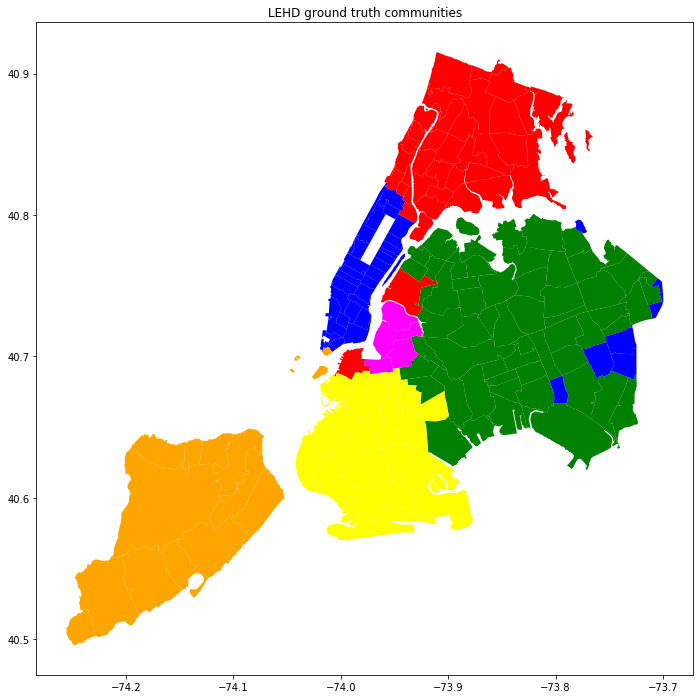

In [22]:
NYCzip = gpd.read_file("NY.geojson") # zip shapefile
if True: #visualize partitions
    visualizePartitionShape(NYCzip, resGt[0], 'zipcode', plttitle = 'LEHD ground truth communities')

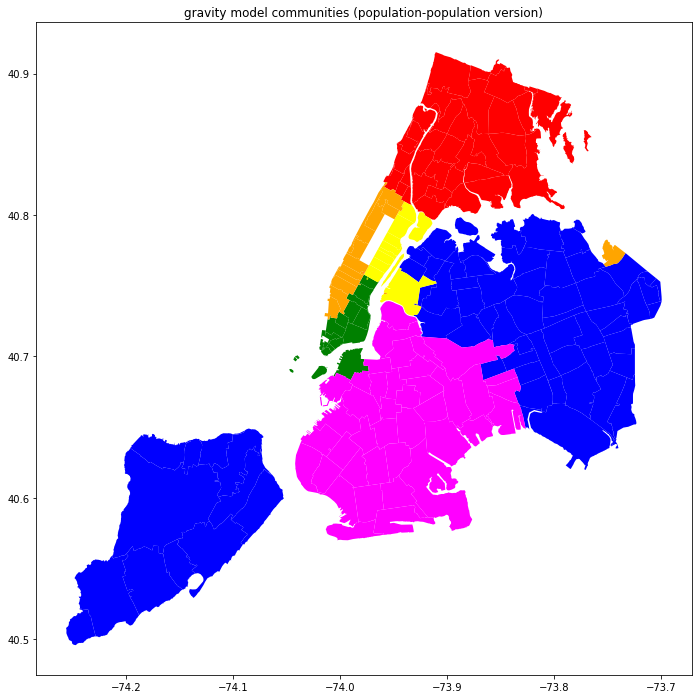

In [25]:
# population-population gravity model results

y = allDataJobs[['O', 'D', 'pred_pop_pop']]
G = nx.from_pandas_edgelist(y, 'O', 'D', 'pred_pop_pop')

resPred = pycombo.execute(G, weight='pred_pop_pop', max_communities=6)

NYCzip = gpd.read_file("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/NY.geojson")
if True: #visualize partitions
    visualizePartitionShape(NYCzip, resPred[0], 'zipcode', plttitle = 'gravity model communities (population-population version)')

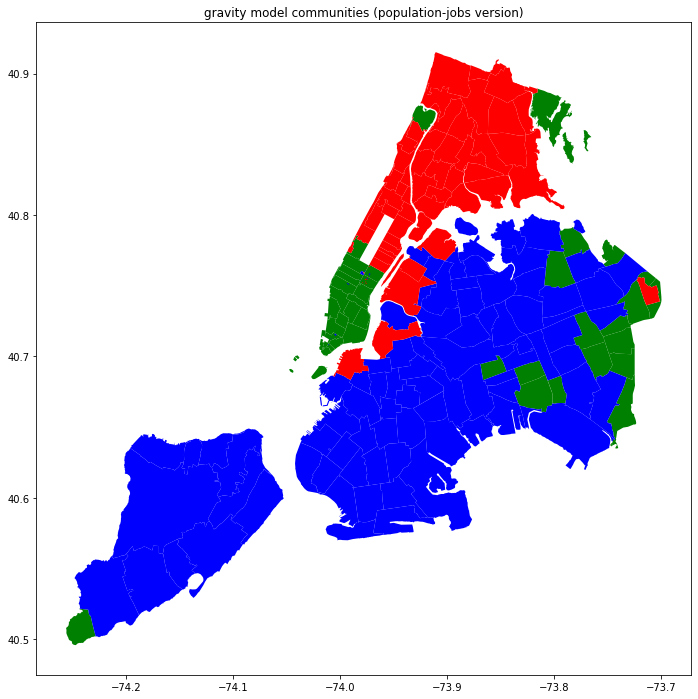

In [26]:
# gravity model results

y = allDataJobs[['O', 'D', 'pred_pop_jobs']]
G = nx.from_pandas_edgelist(y, 'O', 'D', 'pred_pop_jobs')

resPred = pycombo.execute(G, weight='pred_pop_jobs')

NYCzip = gpd.read_file("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/NY.geojson")
if True: #visualize partitions
    visualizePartitionShape(NYCzip, resPred[0], 'zipcode', plttitle = 'gravity model communities (population-jobs version)')

In [27]:
## gravity modes results different from ground truth communities